In [ ]:
#|default_exp utils 

In [ ]:
#| export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder


from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.mps import *

## Reseed CB
This callback facilitate using different seeds while still keeping the training reproducable by reporting the seed on each use.

In [ ]:
#| export
class ReseedCB(Callback):
    order = 0
    def __init__(self): self.gen, self.new_seed = torch.Generator(), None
    def before_fit(self, learn): 
        self.set_seed(self.new_seed)
        print('Using seed', self.new_seed)
    def set_seed(self, seed=None): 
        if seed is None: 
            self.new_seed = torch.randint(2**31, [1], generator=self.gen).item()
            print(f"New seed: {self.new_seed}")
        else:
            self.new_seed = seed
        set_seed(self.new_seed)
        return self.new_seed
    def previous(self): self.set_seed(self.new_seed)
    def new(self): self.set_seed()

In [ ]:
reseed=ReseedCB()

Seed is set twice, on pervious|new|set_seed and before every seed

In [ ]:
reseed.before_fit(None)
print(torch.randn(10))
reseed.before_fit(None)
print(torch.randn(10))

New seed: 205811062
Using seed 205811062
tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])
Using seed 205811062
tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])


In [ ]:
reseed.previous()
print(torch.randn(10)) # useful during init
reseed.before_fit(None)
print(torch.randn(10))

tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])
Using seed 205811062
tensor([-0.5644, -1.8079,  0.5900,  0.6734,  0.0040, -0.6066, -0.3101,  0.8848,
         0.0541,  0.3965])


In [ ]:
reseed.set_seed(42)
print(torch.randn(10))
reseed.before_fit(None)
print(torch.randn(10))

tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
         0.4617,  0.2674])
Using seed 42
tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
         0.4617,  0.2674])


In [ ]:
reseed.new()
print(torch.randn(10))
reseed.before_fit(None)
print(torch.randn(10))

New seed: 1155489284
tensor([ 0.1857,  0.5785,  0.1219, -0.4333, -0.8358, -0.3888, -1.5829, -0.6018,
         0.2697,  0.2101])
Using seed 1155489284
tensor([ 0.1857,  0.5785,  0.1219, -0.4333, -0.8358, -0.3888, -1.5829, -0.6018,
         0.2697,  0.2101])


## Speed of Training

Unfortunately the multiprocessing is a bit slower on MPS as the main process has to share the number of OMP Threads (the value cannot be changed after fork). So to avoid warnings it is set to 1. Which makes the dataloader a bit slower.  To workaround this i've added cache_dataset_as_dict

It improves the performance 4x for large batch sizes from:
- 16 sec per fit(5)

to:

- 5 sec initial loading time
- 3.6 sec per fit(5)

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import get_model, init_weights

In [ ]:
## lazy metrics and progress bar 

In [ ]:
try:
    me = Mean(device=def_device)
except TypeError as e: # on mps device
    assert "MPS framework doesn't support float64" in str(e)
    print(str(e))

Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.


In [ ]:
#| export
from torcheval.metrics import Metric, Mean
class LazyMean(Mean):
    def __init__(self): 
        super().__init__()
        self.buffer = []
        
    def reset(self):
        super().reset()
        self.buffer = []
    
    def to(self, device): pass # ignore we compute on cpu

    def update(self, val, weight=tensor(1.0)): self.buffer.append((val.detach(), tensor(weight).detach()))

    def compute(self):
        for val,w in self.buffer: super().update(val.to('cpu'), weight=w.to('cpu'))
        self.buffer = []    
        return super().compute() 

In [ ]:
#| export
from copy import copy
from miniai.learner import Mean, master_bar, progress_bar
class LazyMetricsCB(Callback):
    order = MetricsCB.order
    def __init__(self, *ms, device=def_device, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = LazyMean()
        self.device = def_device

    def _log(self, d): print(d)
    def before_fit(self, learn): 
        learn.metrics = self 
        self.device = [*(cb.device for cb in learn.cbs if isinstance(cb, DeviceCB)), self.device][0]
                
    def before_epoch(self, learn): 
        for o in self.all_metrics.values(): 
            o.reset()
            o.to(self.device)
    
    @torch.no_grad()
    def after_epoch(self, learn):
        log = {k:f'{to_cpu(v.compute()):.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    @torch.no_grad()
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values(): m.update(learn.preds, y)
        self.loss.update(learn.loss, weight=len(x))


In [ ]:
#| export
class LazyProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): 
        self.plot = plot
        self.count = 0
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.dev_losses = []
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
        if self.plot:
            for l in self.dev_losses: self.losses.append(to_cpu(l))
            self.dev_losses=[]
            #print(self.losses[:10])
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])
        
    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        #learn.dl.comment = f'{learn.loss:.3f}' # not sure how it is being used
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.dev_losses.append(learn.loss.detach())

In [ ]:
#| export
import time

def _format_stats(stats):
    return f"{stats.mean():.2f} ± {stats.std():.2f}"

class TimeItCB(Callback):
    def __init__(self):
        self.reset()
    def tick(self): return time.time()
         
    def reset(self):
        self.start = self.tick()
        self.setup = None
        self.batches = {True:[], False:[]}
        self.epochs = {True:[], False:[]}
        self.samples = {True:[], False:[]}
    def before_fit(self, learn):
        self.reset()
        
    def before_batch(self, learn):
        if self.setup is None: self.setup = self.tick() - self.start
        self.batches[learn.training].append(self.tick())
    
    def after_batch(self, learn):
        self.batches[learn.training][-1] = self.tick() - self.batches[learn.training][-1]
        self.samples[learn.training].append(learn.batch[0].shape[0])
    
    def before_epoch(self, learn):
        self.epochs[learn.training].append(self.tick())
    
    def after_epoch(self, learn):
        self.epochs[learn.training][-1] = self.tick() - self.epochs[learn.training][-1]
    
    def after_fit(self, learn):
        self.total = self.tick() - self.start
        self.setup = self.setup / self.total
        self.batches = {k:np.array(v) for k,v in self.batches.items()}
        self.epochs = {k:np.array(v) for k,v in self.epochs.items()}
        self.samples = {k:np.array(v) for k,v in self.samples.items()}
        self.print_stats()
    
    def print_stats(self): 
        print(f"Fit {len(self.epochs[True])} in: {self.total:.2f}s, setup: {self.setup:.2f}s, {_format_stats(self.epochs[True])}s per epoch, {_format_stats(self.batches[True])}s per batch")
        #print(f" samples/sec: {self.samples[True].sum() / self.total:.2f}s, time_in_val: {self.epochs[False].sum() / self.total:.2f}s")

In [ ]:
#| export
# if spawn is not possible, we can cache the entire dataset in memory after transformations
def _with_features(ds):
    setattr((l:=fc.L(ds)), 'features', ds.features)
    return l 
def cache_dataset_as_dict(dd): return {dsn: _with_features(ds) for dsn,ds in dd.items()}

In [ ]:
cbs = [DeviceCB(), LazyMetricsCB(accuracy=MulticlassAccuracy()), LazyProgressCB(plot=True), TimeItCB()]
eager_cbs = [DeviceCB(), LazyMetricsCB(accuracy=MulticlassAccuracy()), LazyProgressCB(plot=True), TimeItCB()]

In [ ]:
bs = 1024
xmean, xstd = 0.28, 0.35
name = "fashion_mnist"
def to_tensor_tfm(b, mean, std, xl='image'): 
    b[xl] = [(TF.to_tensor(o)-mean)/std for o in b[xl]]
    return b

dsd = load_dataset(name)
tds = dsd.with_transform(partial(to_tensor_tfm, mean=xmean, std=xstd))

Found cached dataset fashion_mnist (/Users/pczapla/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4, )
set_seed(42)
learn = TrainLearner(get_model().to('cpu').apply(init_weights), dls, F.cross_entropy, lr=1e-2, cbs=eager_cbs, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.878,0.341,0,train
0.877,0.339,0,eval
0.906,0.255,1,train
0.884,0.321,1,eval


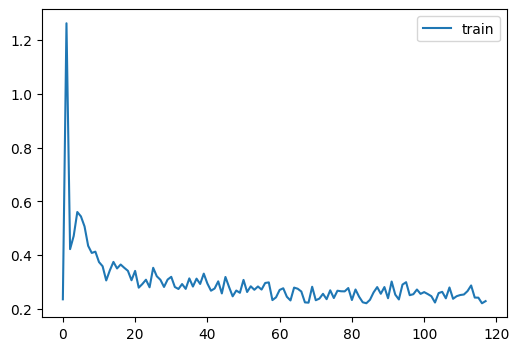

Fit 2 in: 11.40s, setup: 0.01s, 4.91 ± 0.06s per epoch, 0.01 ± 0.00s per batch


In [ ]:
learn.fit(2)

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4, )
set_seed(42)
learn = TrainLearner(get_model().to('cpu').apply(init_weights), dls, F.cross_entropy, lr=1e-2, cbs=cbs, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.766,0.669,0,train
0.834,0.453,0,eval
0.863,0.380,1,train
0.852,0.395,1,eval


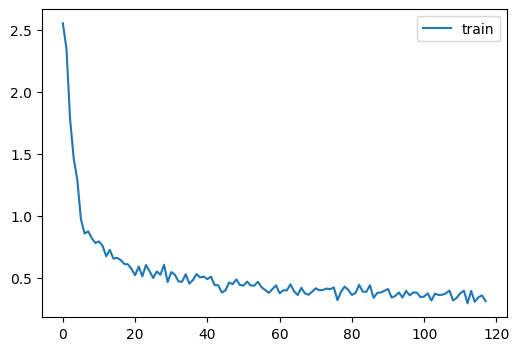

Fit 2 in: 10.95s, setup: 0.01s, 4.72 ± 0.10s per epoch, 0.01 ± 0.00s per batch


In [ ]:
learn.fit(2)

In [ ]:
%%timeit -n 1 -r 1
tds.cached = cache_dataset_as_dict(tds)

4.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
set_seed(42)
dls_cached = DataLoaders.from_dd(tds.cached, bs, num_workers=0)
learn = TrainLearner(get_model().to('cpu').apply(init_weights), dls_cached, F.cross_entropy, lr=1e-2, cbs=cbs, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.766,0.669,0,train
0.834,0.453,0,eval
0.863,0.380,1,train
0.852,0.395,1,eval


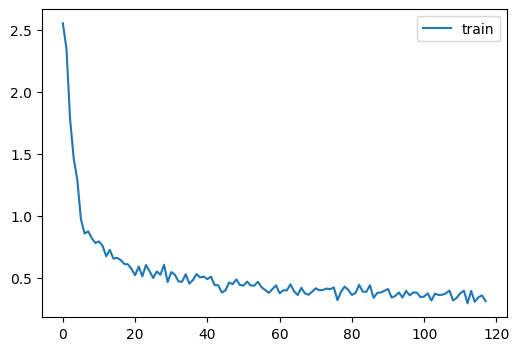

Fit 2 in: 1.58s, setup: 0.02s, 0.69 ± 0.04s per epoch, 0.01 ± 0.00s per batch


In [ ]:
learn.fit(2)

In [ ]:
set_seed(42)
dls_cached = DataLoaders.from_dd(tds.cached, bs, num_workers=0)
learn = TrainLearner(get_model().to('cpu').apply(init_weights), dls_cached, F.cross_entropy, lr=1e-2, cbs=eager_cbs, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.766,0.669,0,train
0.834,0.453,0,eval
0.863,0.380,1,train
0.852,0.395,1,eval


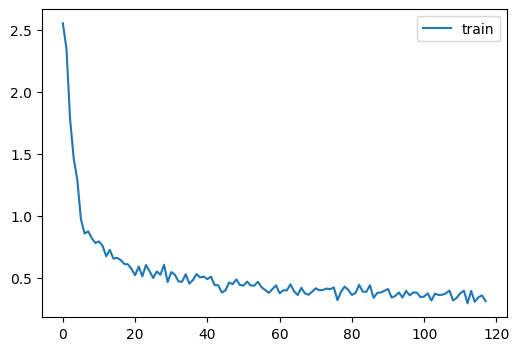

Fit 2 in: 1.56s, setup: 0.02s, 0.68 ± 0.05s per epoch, 0.01 ± 0.00s per batch


In [ ]:
learn.fit(2)

In [ ]:
len(tds.cached['train']), bs

(60000, 16384)

## Export

In [ ]:
import nbdev; nbdev.nbdev_export()